In [3]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import findspark and initialize. 
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.sql.types import IntegerType, DoubleType



In [4]:
#initialize. 
findspark.init()
# Start Spark session
spark = SparkSession.builder.appName("Dementia").getOrCreate()

In [5]:
# Read in data
url = "https://dementia-data-2024-project-4.s3.us-west-2.amazonaws.com/dementia_patients_health_data.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("dementia_patients_health_data.csv"), sep=",", header=True)


# Show DataFrame
df.show()

+--------+------------------+---------+-----------------+-----------------+------------------+------------------+------------+------------+---+----------------+-------------+------+--------------+--------------+--------+-----------------+-----------------+---------------------+------------------+------------------+-------------+-------------------------+--------+
|Diabetic|      AlcoholLevel|HeartRate| BloodOxygenLevel|  BodyTemperature|            Weight|         MRI_Delay|Prescription|Dosage in mg|Age| Education_Level|Dominant_Hand|Gender|Family_History|Smoking_Status| APOE_ε4|Physical_Activity|Depression_Status|Cognitive_Test_Scores|Medication_History|    Nutrition_Diet|Sleep_Quality|Chronic_Health_Conditions|Dementia|
+--------+------------------+---------+-----------------+-----------------+------------------+------------------+------------+------------+---+----------------+-------------+------+--------------+--------------+--------+-----------------+-----------------+------------

In [6]:
df.printSchema()

root
 |-- Diabetic: string (nullable = true)
 |-- AlcoholLevel: string (nullable = true)
 |-- HeartRate: string (nullable = true)
 |-- BloodOxygenLevel: string (nullable = true)
 |-- BodyTemperature: string (nullable = true)
 |-- Weight: string (nullable = true)
 |-- MRI_Delay: string (nullable = true)
 |-- Prescription: string (nullable = true)
 |-- Dosage in mg: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Dominant_Hand: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Family_History: string (nullable = true)
 |-- Smoking_Status: string (nullable = true)
 |-- APOE_ε4: string (nullable = true)
 |-- Physical_Activity: string (nullable = true)
 |-- Depression_Status: string (nullable = true)
 |-- Cognitive_Test_Scores: string (nullable = true)
 |-- Medication_History: string (nullable = true)
 |-- Nutrition_Diet: string (nullable = true)
 |-- Sleep_Quality: string (nullable = true)
 |-- Chronic_Health_

In [7]:
#convert the data types

df = df.withColumn("AlcoholLevel", df["AlcoholLevel"].cast(DoubleType()))
df = df.withColumn("HeartRate", df["HeartRate"].cast(IntegerType()))
df = df.withColumn("BloodOxygenLevel", df["BloodOxygenLevel"].cast(DoubleType()))
df = df.withColumn("BodyTemperature", df["BodyTemperature"].cast(DoubleType()))
df = df.withColumn("Weight", df["Weight"].cast(DoubleType()))
df = df.withColumn("MRI_Delay", df["MRI_Delay"].cast(DoubleType()))
df = df.withColumn("Age", df["Age"].cast(IntegerType()))
df = df.withColumn("Cognitive_Test_Scores", df["Cognitive_Test_Scores"].cast(IntegerType()))
df = df.withColumn("Dementia", df["Dementia"].cast(IntegerType()))

In [8]:
df.summary().show()

24/02/04 14:33:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------+-----------------+-----------------+----------------+-------------+------+--------------+--------------+--------+-----------------+-----------------+---------------------+------------------+------------------+-------------+-------------------------+------------------+
|summary|          Diabetic|       AlcoholLevel|         HeartRate| BloodOxygenLevel|   BodyTemperature|            Weight|         MRI_Delay|Prescription|     Dosage in mg|              Age| Education_Level|Dominant_Hand|Gender|Family_History|Smoking_Status| APOE_ε4|Physical_Activity|Depression_Status|Cognitive_Test_Scores|Medication_History|    Nutrition_Diet|Sleep_Quality|Chronic_Health_Conditions|          Dementia|
+-------+------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+----------

In [11]:
# Create TempView
df.createOrReplaceTempView("dementia_data")

In [12]:
# factors by dementia status
query = """
    SELECT
        AVG(HeartRate) AS avg_heart_rate,
        AVG(BloodOxygenLevel) AS avg_blood_oxygen,
        AVG(BodyTemperature) AS avg_body_temperature,
        AVG(Weight) AS avg_weight,
        AVG(Age) AS avg_age,
        Dementia
    FROM dementia_data
    GROUP BY Dementia
"""

result = spark.sql(query)
result.show()



+-----------------+-----------------+--------------------+-----------------+-----------------+--------+
|   avg_heart_rate| avg_blood_oxygen|avg_body_temperature|       avg_weight|          avg_age|Dementia|
+-----------------+-----------------+--------------------+-----------------+-----------------+--------+
| 79.5360824742268|95.01047449783889|   36.77659805923553|73.58299101270836| 74.3257731958763|       1|
|79.23883495145631|95.42906965312902|   36.74730630525481|75.01665133053221|75.45631067961165|       0|
+-----------------+-----------------+--------------------+-----------------+-----------------+--------+



In [13]:
#convert to pandas dataframe
averages_dementia = result.toPandas()
averages_dementia


,avg_heart_rate,avg_blood_oxygen,avg_body_temperature,avg_weight,avg_age,Dementia
0,79.536082,95.010474,36.776598,73.582991,74.325773,1
1,79.238835,95.429070,36.747306,75.016651,75.456311,0


In [14]:
#melt results to create grouped bar plot
result_melted = pd.melt(averages_dementia, id_vars='Dementia', var_name='Factor', value_name='Average Value')


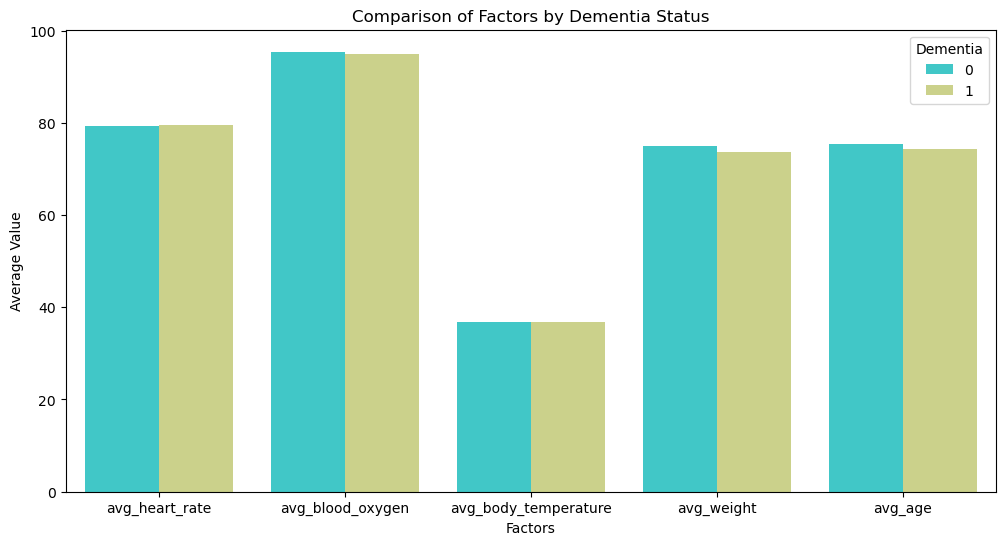

In [15]:
#dementia status by multiple factors 
plt.figure(figsize=(12, 6))
sns.barplot(x='Factor', y='Average Value', hue='Dementia', data=result_melted, palette='rainbow')
plt.title('Comparison of Factors by Dementia Status')
plt.xlabel('Factors')
plt.ylabel('Average Value')
plt.show()

In [16]:
# dementia status by sleep quality
query = """
    SELECT
        Sleep_Quality,
        COUNT(*) AS Dementia_Count
    FROM dementia_data
    WHERE Sleep_Quality IN ('Poor', 'Good') 
    GROUP BY Sleep_Quality
"""
sleep_result = spark.sql(query)
sleep_result_df = sleep_result.toPandas()
sleep_result_df

,Sleep_Quality,Dementia_Count
0,Good,466
1,Poor,534


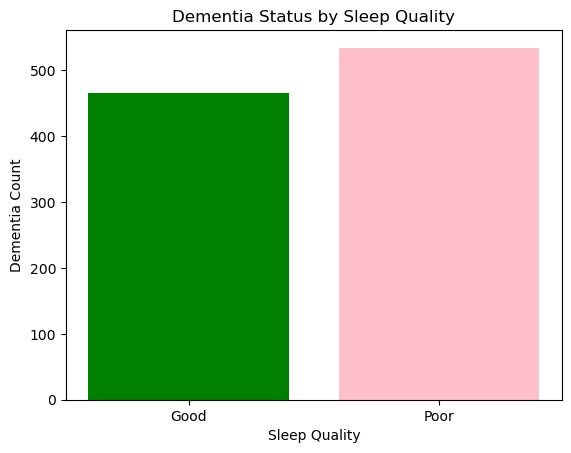

In [17]:
#plot for dementia status by sleep quality
plt.bar(sleep_result_df['Sleep_Quality'], sleep_result_df['Dementia_Count'], color=['green', 'pink'])
plt.xlabel('Sleep Quality')
plt.ylabel('Dementia Count')
plt.title('Dementia Status by Sleep Quality')
plt.show()

In [18]:
#dementia status by chronic health conditions
query = """
    SELECT
        Chronic_Health_Conditions,
        COUNT(*) AS Dementia_Count
    FROM dementia_data
    GROUP BY Chronic_Health_Conditions
"""

chronic_health_result = spark.sql(query)
chronic_health_result_df = chronic_health_result.toPandas()
chronic_health_result_df

,Chronic_Health_Conditions,Dementia_Count
0,None,179
1,Heart Disease,155
2,Diabetes,513
3,Hypertension,153


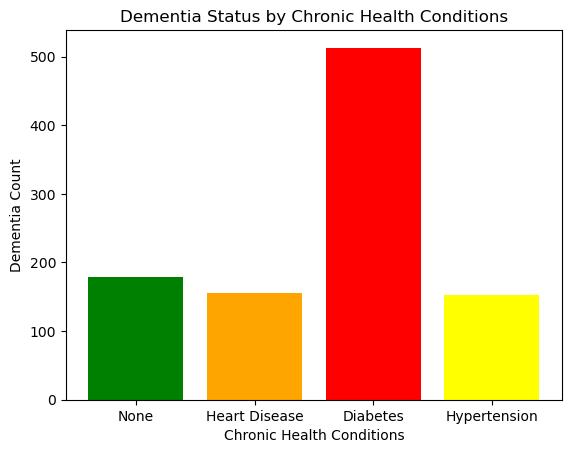

In [19]:
# plot for dementia status by chronic health conditions
plt.bar(chronic_health_result_df['Chronic_Health_Conditions'], chronic_health_result_df['Dementia_Count'], color=['green', 'orange', 'red', 'yellow'])
plt.xlabel('Chronic Health Conditions')
plt.ylabel('Dementia Count')
plt.title('Dementia Status by Chronic Health Conditions')
plt.show()

In [20]:
# dementia status by family history
query = """
    SELECT
        Family_History,
        COUNT(*) AS Dementia_Count
    FROM dementia_data
    GROUP BY Family_History
"""


family_history_result = spark.sql(query)
family_history_result_df = family_history_result.toPandas()
family_history_result_df


,Family_History,Dementia_Count
0,No,480
1,Yes,520


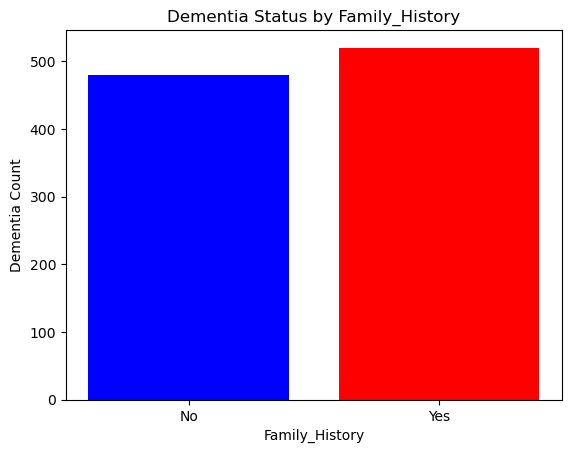

In [21]:
#plot for dementia status by family history
plt.bar(family_history_result_df['Family_History'], family_history_result_df['Dementia_Count'], color=['blue', 'red'])
plt.xlabel('Family_History')
plt.ylabel('Dementia Count')
plt.title('Dementia Status by Family_History')
plt.show()

In [24]:
# dementia count by cognitive test score
query = """
    SELECT
        Cognitive_Test_Scores,
        COUNT(*) AS Dementia_Count
    FROM dementia_data
    WHERE Dementia = 1
    GROUP BY Cognitive_Test_Scores
    ORDER BY Cognitive_Test_Scores DESC
"""

cog_test_scores_result = spark.sql(query)
cog_test_scores_result_df = cog_test_scores_result.toPandas()
cog_test_scores_result_df

,Cognitive_Test_Scores,Dementia_Count
0,7,65
1,6,60
2,5,78
3,4,55
4,3,54
5,2,56
6,1,57
7,0,60


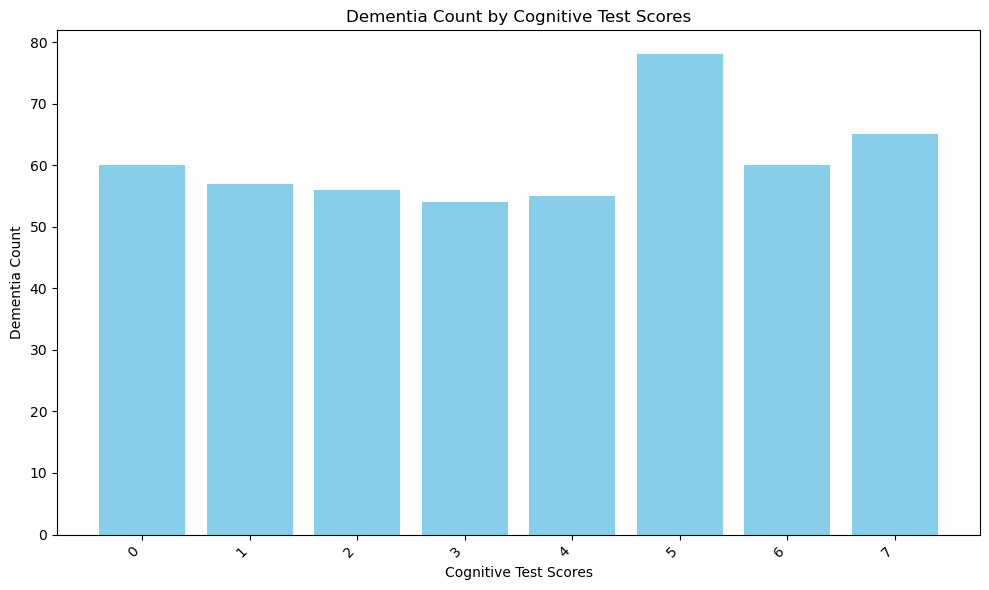

In [25]:
#plot for dementia count by cognitive test score
plt.figure(figsize=(10, 6))
plt.bar(cog_test_scores_result_df['Cognitive_Test_Scores'], cog_test_scores_result_df['Dementia_Count'], color='skyblue')
plt.xlabel('Cognitive Test Scores')
plt.ylabel('Dementia Count')
plt.title('Dementia Count by Cognitive Test Scores')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()